In [1]:
import torch
import rasterio
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch.nn import BCELoss
from unet_model import UNet
from torchgeo.samplers import RandomBatchGeoSampler
from torchgeo.datasets import Sentinel2, stack_samples
from torch.utils.tensorboard import SummaryWriter
from RasterDataset import RasterDataset
from torchmetrics.functional import precision_recall
from sklearn.utils import class_weight 
import matplotlib.pyplot as plt
from typing import Dict, List
from torch import nn
%load_ext tensorboard
%tensorboard --logdir=runs --port=6006

/anaconda/envs/perma/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reusing TensorBoard on port 6006 (pid 476893), started 2 days, 17:26:58 ago. (Use '!kill 476893' to kill it.)

In [2]:
class MinMaxNormalize(nn.Module):
    """Normalize channels to the range [0, 1] using min/max values."""

    def __init__(self, min: List[float], max: List[float]) -> None:
        super().__init__()
        self.min = torch.tensor(min)[:, None, None]
        self.max = torch.tensor(max)[:, None, None]
        self.denominator = self.max - self.min

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = inputs
        # Batch
        if x.ndim == 4:
            x = (x - self.min[None, ...]) / self.denominator[None, ...]
        # Sample
        else:
            x = (x - self.min) / self.denominator

        inputs = x.clamp(0, 1)
        return inputs

In [9]:
torch.cuda.empty_cache()
# load model
model_name = 'herschel_unvalidated'
model_path = '../models/' + model_name

model = UNet(n_channels =7, n_classes=1)
model.load_state_dict(torch.load(model_path))

min_values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max_values = [33.0, 456.0, 12472.0, 12112.0, 11816.0, 12208.0, 3537.0]

transforms = torch.nn.Sequential(
    MinMaxNormalize(min_values, max_values)
        )

test_site = '../chopped_data/herschel'
test= RasterDataset(root_list=[test_site, test_site + '_val'])
sampler = RandomBatchGeoSampler(test, size=64, length=500, batch_size=32)
test_dataloader = DataLoader(test, num_workers = 6, batch_sampler=sampler, collate_fn=stack_samples)

In [10]:
def f1_score(precision, recall):
    return (2 * (precision * recall) / (precision + recall))

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]

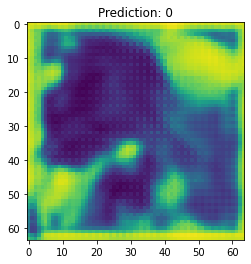

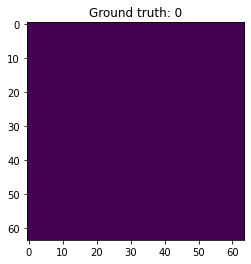

  0%|                                                                                            | 0/15 [00:05<?, ?it/s]

tensor([[[6.4912e-02, 2.8484e-02, 7.6972e-03],
         [5.9157e-02, 2.7081e-02, 6.8954e-03],
         [6.2204e-02, 3.0796e-02, 4.8910e-03],
         ...,
         [3.4868e-02, 1.7008e-02, 8.0180e-05],
         [3.2414e-02, 1.1641e-02, 8.0180e-05],
         [2.8097e-02, 5.3666e-03, 8.0180e-05]],

        [[6.0934e-02, 2.7741e-02, 2.5657e-03],
         [5.9326e-02, 2.5347e-02, 6.0135e-03],
         [6.0173e-02, 2.7741e-02, 1.1867e-02],
         ...,
         [3.7576e-02, 1.9320e-02, 8.0180e-05],
         [3.1313e-02, 1.1641e-02, 8.0180e-05],
         [2.9452e-02, 8.2563e-03, 8.0180e-05]],

        [[6.1273e-02, 2.5925e-02, 3.0468e-03],
         [6.1950e-02, 2.7741e-02, 5.1315e-03],
         [6.1781e-02, 2.9145e-02, 1.0504e-02],
         ...,
         [4.7478e-02, 2.3943e-02, 8.0180e-05],
         [3.7068e-02, 1.4779e-02, 3.2072e-04],
         [3.7661e-02, 1.7668e-02, 5.4522e-03]],

        ...,

        [[6.5081e-02, 3.3108e-02, 1.5234e-02],
         [5.8480e-02, 3.1044e-02, 1.0022e-02]

AttributeError: 'Tensor' object has no attribute 'astype'

In [13]:
with torch.no_grad():
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    for i, test_sample in enumerate(tqdm(test_dataloader)):
        test_data = test_sample["image"]
        test_labels = test_data[:,0,:,:]
        test_img = test_data[:,1:,:,:]
        test_img = transforms(test_img)
                
        test_pred = model(test_img.float())
        
        # plotting
#         plt.imshow(test_pred[0][0])
#         plt.title('Prediction: ' + str(i))
#         plt.show()
#         plt.imshow(test_labels[0])
#         plt.title('Ground truth: ' + str(i))
#         plt.show()
        
#         red = test_img[1,4,:,:]
#         green = test_img[1,3,:,:]
#         blue = test_img[1,2,:,:]
#         rgb = torch.stack((red, green, blue), dim=2)
#         print(rgb)
#         plt.imshow(rgb.astype(np.float64))
#         plt.show()
#         assert 0
        precision, recall = precision_recall(test_pred, test_labels)
        total_precision += precision
        total_recall += recall
        
        f1 = f1_score(precision, recall)
        total_f1 += f1
    print("Recall", total_recall / len(test_dataloader))
    print("Precision", total_precision / len(test_dataloader))
    print("F1", total_f1 / len(test_dataloader))